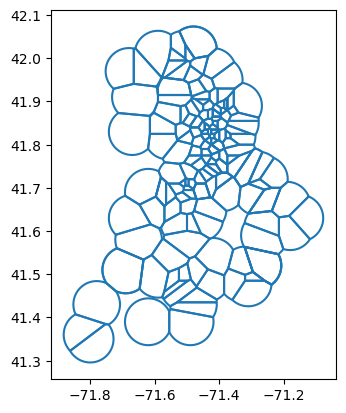

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from scipy.spatial import Voronoi
import numpy as np
import matplotlib.pyplot as plt

# Load store data
loc_data = pd.read_csv('dunkin.csv')

# Convert store data to GeoDataFrame
geometry = [Point(xy) for xy in zip(loc_data.lon, loc_data.lat)]
gdf = gpd.GeoDataFrame(loc_data, geometry=geometry)
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg=3857)

# Convert 5 miles to meters (1 mile = 1609.34 meters)
five_mile_radius = 5 * 1609.34

# Generate 5-mile radius buffers around each point
gdf['buffer'] = gdf.geometry.buffer(five_mile_radius)

# Use the buffer geometry for future plotting purposes
gdf = gdf[['branch', 'buffer']].rename(columns={'buffer': 'geometry'})

# Calculate centroids of each polygon
gdf['centroid'] = gdf.geometry.centroid

# Extract the centroids as a numpy array for Voronoi diagram creation
centroids = np.array([(point.x, point.y) for point in gdf['centroid']])

# Define the bounding box with a slight extension to allow all polygons to show on plot
min_x, min_y, max_x, max_y = unary_union(gdf.geometry).bounds
buffer_distance = five_mile_radius
bbox_extension = 2 * buffer_distance  

dummy_points = [
    [min_x - bbox_extension, min_y - bbox_extension],
    [min_x - bbox_extension, max_y + bbox_extension],
    [max_x + bbox_extension, min_y - bbox_extension],
    [max_x + bbox_extension, max_y + bbox_extension]
]

centroids = np.vstack([centroids, dummy_points])

# Create the Voronoi diagram
vor = Voronoi(centroids)

# Create a list to hold the resulting geometries
result_geometries = []

# Define the bounding box to clip Voronoi regions (extended version)
bounding_box = Polygon([
    (min_x - bbox_extension, min_y - bbox_extension),
    (min_x - bbox_extension, max_y + bbox_extension),
    (max_x + bbox_extension, max_y + bbox_extension),
    (max_x + bbox_extension, min_y - bbox_extension)
])

# Iterate through Voronoi regions and branch polygons
for region_idx, point_idx in enumerate(vor.point_region):
    region = vor.regions[point_idx]
    if not -1 in region:  
        # Create a polygon for the region
        polygon = Polygon([vor.vertices[i] for i in region])
        # Clip the region with the bounding box and branch polygon
        polygon = polygon.intersection(bounding_box)
        if region_idx < len(gdf):  # Only process actual data points, not dummy ones
            branch_polygon = gdf.geometry.iloc[region_idx]
            clipped_region = polygon.intersection(branch_polygon)
            result_geometries.append(clipped_region)

# Create a new gdf with the resulting geometries
result_gdf = gpd.GeoDataFrame(geometry=result_geometries, crs=gdf.crs)

# Reproject
result_gdf = result_gdf.to_crs(epsg=4326)
gdf = gdf.to_crs(epsg=4326)

# Plot the results
result_gdf.boundary.plot()
plt.show()


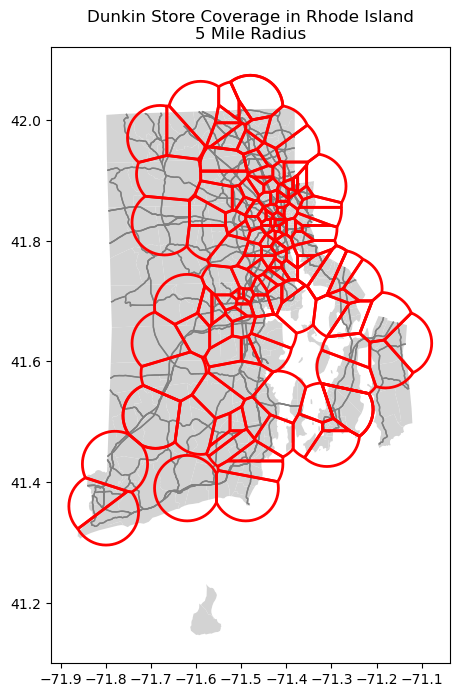

In [6]:
# RI state outline and road shp files
ri_state_shp = 'cb_2023_44_bg_500k.shp'
ri_roads_shp = 'tl_2023_44_prisecroads.shp'

gdf_state = gpd.read_file(ri_state_shp)
gdf_roads = gpd.read_file(ri_roads_shp)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot the base RI map layer in light gray
gdf_state.plot(ax=ax, color='lightgray')

# Overlay the roads layer in gray with a line width
gdf_roads.plot(ax=ax, color='gray', linewidth=1, linestyle='-', edgecolor='black')

# Overlay the store radius layer in red for contrast
result_gdf.boundary.plot(ax=ax, color='red', linewidth=2)

# Generate the plot
plt.title('Dunkin Store Coverage in Rhode Island\n5 Mile Radius')
plt.show()